In [18]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OrdinalEncoder, MinMaxScaler
import matplotlib.pyplot as plt

In [19]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [20]:
passangers = pd.read_csv('../titanic/train.csv')
passangers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Looking at the data set

In [21]:
passangers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can observe that *age, cabin and embarked* attributes have a lot of null values, we'll tackle that later with a regression or with a statistical property.

In [22]:
passangers.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Getting rid of attributes that can make the problem more complicated or can't provide enough information 

In [23]:
passangers.drop('Name', axis = 1, inplace = True)
passangers.drop('Ticket', axis = 1, inplace = True)
passangers.drop('Cabin', axis = 1, inplace = True) # Can make the problem a little bit more complicated, but in future iterations will be included
passangers.drop('Embarked', axis = 1, inplace = True)

In [24]:
passangers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


Assigning a value for the sex attribute

In [25]:
cat_encoder = OrdinalEncoder()
sex_cat = passangers[['Sex']]
sex_encoded = cat_encoder.fit_transform(sex_cat)
passangers['Sex'] = sex_encoded

Combining the SibSp and Parch attribute into just a Family attribute

In [26]:
passangers['Family'] = passangers['SibSp'] + passangers['Parch']
passangers.drop('SibSp', axis = 1, inplace = True)
passangers.drop('Parch', axis = 1, inplace = True)

In [27]:
corr_matrix = passangers.corr()

We can see what we thought, with Pearson's r we appreciate that the survived factor correlates mostly with the economic class (Pclass and fare) and sex

In [28]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Family         0.016639
PassengerId   -0.005007
Age           -0.077221
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

Now we get rid of all the null values for the Age attribute (in reality for all attributes, but for now in the trainign set only for Age) using a iterative imputer, it'll fill the null values with a reggresion model 

In [29]:
imputer = IterativeImputer()
x = imputer.fit_transform(passangers)
passangers_nnv = pd.DataFrame(x, columns=passangers.columns, # no null values
                              index=passangers.index)

We can appreciate that the Age attribute is skewed and it has a long tail to the rigth, we'll try to make a normal curve using a root or a log of the data

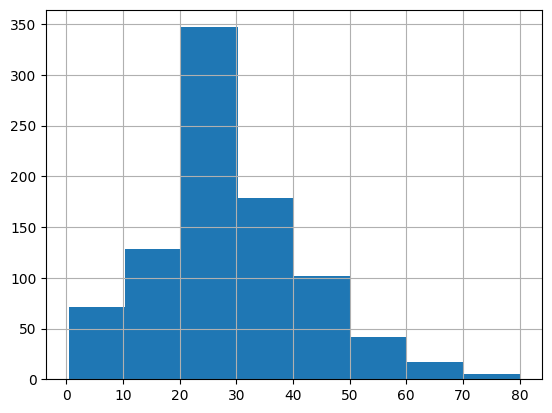

In [30]:
passangers_nnv['Age'].hist(bins=8)
plt.show()

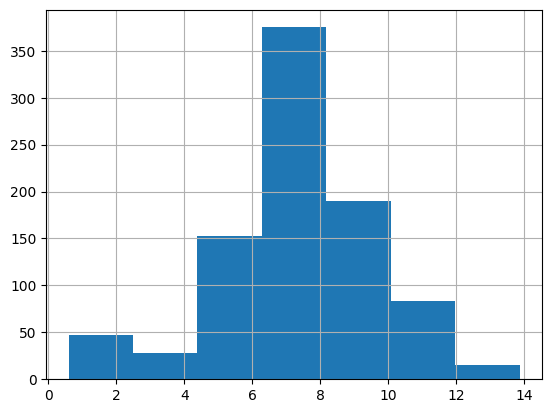

In [31]:
passangers_nnv['Age'] = np.power(passangers_nnv['Age'], 0.6)
passangers_nnv['Age'].hist(bins=7)
plt.show()